[**Paper**](https://arxiv.org/ftp/arxiv/papers/2204/2204.06806.pdf): YOLO-Pose: Enhancing YOLO for Multi Person Pose Estimation Using Object Keypoint Similarity Loss

[*git*](https://github.com/WongKinYiu/yolov7/tree/pose)

## Import libraries

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import cv2
import numpy as np
import time

from torchvision import transforms

from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [4]:
from platform import python_version
torch.__version__, cv2.__version__, python_version()
# ('1.12.1', '4.6.0', '3.9.13')

('1.12.1', '4.6.0', '3.9.13')

## Pose prerequisites

Download the pre-trained pose estimation model from YOLOv7 official release

wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6-pose.pt

In [25]:
# load model from pre-trained version
weigths = torch.load('D:\gdrive\yolov7-pose\models\yolov7-w6-pose.pt') # replace with your path
model = weigths['model']
#model = model.float().to(device) # get CUDA out of memory on RTX 3080
model = model.float().to(device="cpu")

## Test on image files

In [28]:
def plot_pose_estimation(model, image_path):
    
    image = cv2.imread(image_path)
    image = letterbox(image, 960, stride=64, auto=True)[0]
    image = transforms.ToTensor()(image)
    image = torch.tensor(np.array([image.numpy()]))
    #image = image.to(device)
    
    # set evaluation mode
    _ = model.eval()
    output, _ = model(image)
    
    output = non_max_suppression_kpt(output, 0.25, 0.65, nc=model.yaml['nc'], nkpt=model.yaml['nkpt'], kpt_label=True)
    with torch.no_grad():
        output = output_to_keypoint(output)
    nimg = image[0].permute(1, 2, 0) * 255
    
    nimg = nimg.cpu().numpy().astype(np.uint8)
    nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
    for idx in range(output.shape[0]):
        plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)
        
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(nimg)
    plt.show()

In [29]:
'''
Error on GTX 3080
RuntimeError: CUDA out of memory. Tried to allocate 38.00 MiB (GPU 0; 10.00 GiB total capacity; 9.08 GiB already allocated; 0 bytes free; 9.27 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  
See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

During the experiment, I got CUDA out of memory error. My card is RTX 3080 10GB, belong to a Lenovo Legion Workstation
'''

'\nError on GTX 3080\nRuntimeError: CUDA out of memory. Tried to allocate 38.00 MiB (GPU 0; 10.00 GiB total capacity; 9.08 GiB already allocated; 0 bytes free; 9.27 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  \nSee documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF\n'

In [ ]:
def check_model_memory_consumption(model):
    mem_params = sum([param.nelement()*param.element_size() for param in model.parameters()])
    mem_bufs = sum([buf.nelement()*buf.element_size() for buf in model.buffers()])
    mem = mem_params + mem_bufs # in bytes
    return mem

check_model_memory_consumption(model)

In [ ]:
import torch
torch.cuda.max_memory_allocated()

In [34]:
#pip install GPUtil

def free_gpu_cache():
    from GPUtil import showUtilization as gpu_usage
    from numba import cuda
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()       

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  1% | 20% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  0% |  9% |


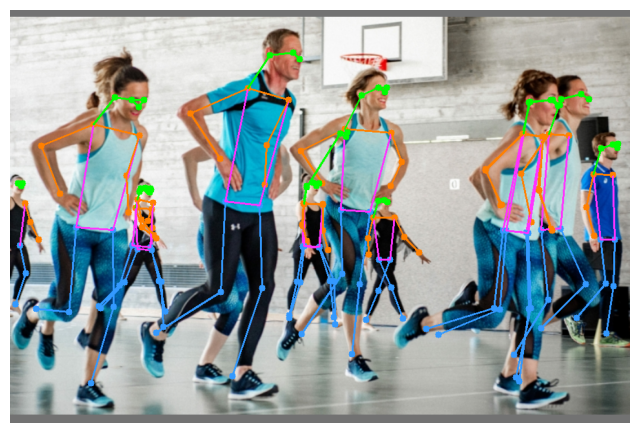

In [35]:
# install GUI backend in Jupter Notebook.
# conda install pyqt
plot_pose_estimation(model, 'yolov7/images/team1.jpg')

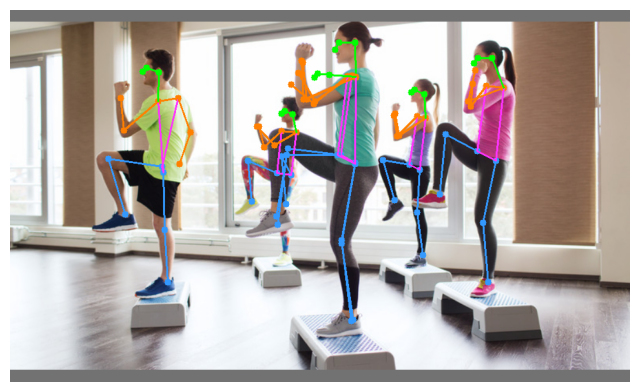

In [36]:
plot_pose_estimation(model, 'yolov7/images/team2.jpg')

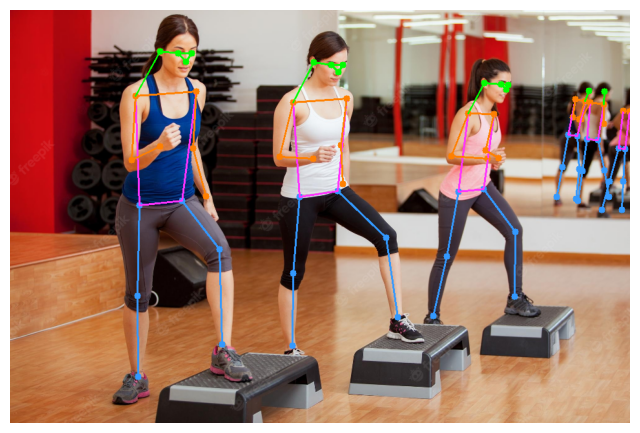

In [37]:
plot_pose_estimation(model, 'yolov7/images/team3.jpg')

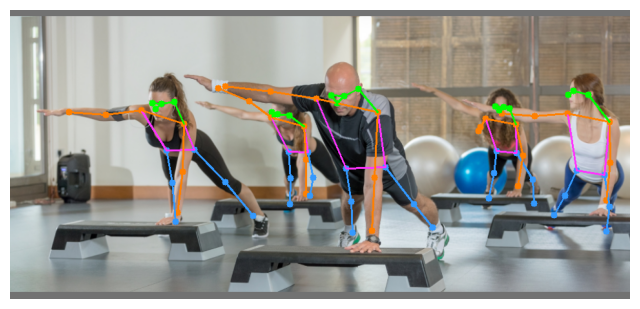

In [38]:
plot_pose_estimation(model, 'yolov7/images/aerobic-stepper.png')

## Test on video files

In [60]:
video_path = 'yolov7\images\football1.mp4'

cap = cv2.VideoCapture(video_path)
if (cap.isOpened() == False):
    print('Error while trying to read video. Please check path again')

Error while trying to read video. Please check path again


In [58]:
# Get the frame width and height.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
frame_width, frame_height 

(0, 0)

In [55]:
# Pass the first frame through `letterbox` function to get the resized image,
# to be used for `VideoWriter` dimensions. Resize by larger side.
vid_write_image = letterbox(cap.read()[1], (frame_width), stride=64, auto=True)[0]
resize_height, resize_width = vid_write_image.shape[:2]

save_name = f"{video_path.split('/')[-1].split('.')[0]}"
# Define codec and create VideoWriter object .
out = cv2.VideoWriter(f"{save_name}_keypoint.mp4",
                    cv2.VideoWriter_fourcc(*'mp4v'), 30,
                    (resize_width, resize_height))

frame_count = 0 # To count total frames.
total_fps = 0 # To get the final frames per second.

In [56]:
while(cap.isOpened):
    # Capture each frame of the video.
    ret, frame = cap.read()
    if ret:
        orig_image = frame
        image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
        image = letterbox(image, (frame_width), stride=64, auto=True)[0] 
        image = transforms.ToTensor()(image)
        image = torch.tensor(np.array([image.numpy()]))
        #image = image.to(device)
        image = image.float()

        # set evaluation mode
        _ = model.eval()
        
        # Get the start time
        start_time = time.time()
        with torch.no_grad():
            output, _ = model(image)
        # Get the end time.
        end_time = time.time()
        # Get the fps.
        fps = 1 / (end_time - start_time)
        # Add fps to total fps.
        total_fps += fps
        # Increment frame count.
        frame_count += 1

        output = non_max_suppression_kpt(output, 0.25, 0.65, nc=model.yaml['nc'], nkpt=model.yaml['nkpt'], kpt_label=True)
        output = output_to_keypoint(output)
        nimg = image[0].permute(1, 2, 0) * 255
        nimg = nimg.cpu().numpy().astype(np.uint8)
        nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
        for idx in range(output.shape[0]):
            plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)

            # Comment/Uncomment the following lines to show bounding boxes around persons.
            xmin, ymin = (output[idx, 2]-output[idx, 4]/2), (output[idx, 3]-output[idx, 5]/2)
            xmax, ymax = (output[idx, 2]+output[idx, 4]/2), (output[idx, 3]+output[idx, 5]/2)
            cv2.rectangle(
                      nimg,
                      (int(xmin), int(ymin)),
                      (int(xmax), int(ymax)),
                      color=(255, 0, 0),
                      thickness=1,
                      lineType=cv2.LINE_AA
            )

        # Write the FPS on the current frame.
        cv2.putText(nimg, f"{fps:.3f} FPS", (15, 30), cv2.FONT_HERSHEY_SIMPLEX,
                      1, (0, 255, 0), 2)
        # Convert from BGR to RGB color format.
        cv2.imshow('image', nimg)
        out.write(nimg)
        # Press `q` to exit.
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 15 but got size 16 for tensor number 1 in the list.

In [ ]:
# Release VideoCapture().
cap.release()
# Close all frames and video windows.
cv2.destroyAllWindows()
# Calculate and print the average FPS.
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")